# Wrangling OpenStreetMap data

OpenStreetMap is an Open Source alternative to proprietary "Maps" software, like Google Maps and Apple Maps.

To someone not familiar with the Open Source world it may look like we are attempting to reinvent the wheel, and while sometimes it is just that, over time many projects are able to overcome their competition.

Some examples of that are Linux, it started small, and eventually overcame UNIX as the standard server operating system, and Python that has grown from a simple programming language to the awesome multipurpose one with many libraries that we have today.

The reason for this is that everyone may use it, study the source code, and contribute to it if they feel like it, and many companies saw the power behind a hive minded community, everyone doing their part, and harnessed it offering support for enterprise use, or some sort of standardization, while improving the code for everyone else, it's a win-win situation.

In the case of OpenStreetMap, anyone may contribute to its database by mapping their own part of the world. It's amazing to think that with a little help from many people we could map the entire world for free.

But, with human generated data, some problems arise, manual input tends to generate not only errors, but inconsistencies too.

The purpose to this project is to audit and improve the data of my current hometown, Curitiba, capital of the state of Paraná, in Brazil.

## Map Area

#### Curitiba, PR, Brazil

* https://www.openstreetmap.org/relation/297514
* https://en.wikipedia.org/wiki/Curitiba

The data was obtained using Mapzen's (https://mapzen.com/) custom extraction, and can be downloaded here (OSM XML):

* https://s3.amazonaws.com/mapzen.odes/ex_eAGW5zLXGHx6F61DQCWq5DyWKMwop.osm.bz2

## Data problems

When first wrangling this dataset, a few problems became evident:

* Over abbreviated or wrong street names
* Wrong or missing postal codes

So, let's fix them!

### First, let's load our dirty data into a SQLite database

The reason for this, is that we can easily do some queries into the data to find the best ways to fix it.

We'll need 2 modules I created:

1. The first is the OSM XML parser (called, well, osmparser), what it does is read a OSM XLM file and fragments it into 5 CSVs so that they can easily be imported to a SQL database, while validating it to the schema we will be using in the database:
  * "nodes.csv"
  * "nodes_tags.csv"
  * "ways.csv"
  * "ways_nodes.csv"
  * "ways_tags.csv"

  This module has the ability to change bad data if needed on the fly too, but we won't be using this function yet!


2. The second module is the SQLite database creator, called sqlcreator (see a pattern here?), which will finally turn the CSVs into a nice database.

In [1]:
import osmparser
import sqlcreator

osmparser.execute('curitiba.osm')
sqlcreator.execute('curitiba_dirty.db')

To communicate with the databases we'll be creating, I created a small module to run our commands, called sqloperations.

Let's test it! How many nodes we have?

In [2]:
import sqloperations as sql

sql.execute('curitiba_dirty.db', 'SELECT COUNT(id) FROM Nodes')

[[(280077,)]]

### Street names

Let's take a look at the street names in our data.

We'll be using a module I created called audit_streetnames to do it. This module not only selects the names from the data, it analyzes them and suggests better ones. If there's any strange names that weren't automatically fixed, they are highlighted by an \*, and we can manually fix them by giving it a dictionary of overrides.

Calling its main function prints all the problems with the street name data and returns a dictionary of fixes that we will use to fix the data afterwards!

Let's take a look into the acceptable street names first:

In [3]:
import audit_streetnames
audit_streetnames.expected

['Rua',
 'Avenida',
 'Travessa',
 'Praça',
 'Rodovia',
 'Alameda',
 'Estrada',
 'Linha',
 'Largo',
 'Marginal']

Street names in Brazil always starts with the type: Rua means Street, Avenida means Avenue, and so on.

Do we have problems with the data?

In [4]:
fixedStreetNames = audit_streetnames.execute('curitiba.osm', True) 
#the second argument adds the * before names that aren't automatically 
#updated if True

Av das Torres => Avenida das Torres
Av Nossa Senhora de Lourdes => Avenida Nossa Senhora de Lourdes
Av Comendador Franco => Avenida Comendador Franco
* Filipinas => Filipinas
Av. Comendador Franco => Avenida Comendador Franco
Av. Coronel Francisco Heráclito Dos Santos => Avenida Coronel Francisco Heráclito Dos Santos
Av. Dr. Dàrio Lopes dos Santos => Avenida Dr. Dàrio Lopes dos Santos
Av. Sete de Setembro => Avenida Sete de Setembro
* Rui Barbosa => Rui Barbosa
* Centro Politécnico da UFPR, Caixa Postal 19100 => Centro Politécnico da UFPR, Caixa Postal 19100
* BR-116 => BR-116
* Vicente za => Vicente za
R. Agudos do Sul => Rua Agudos do Sul
R. Sargento Erwin => Rua Sargento Erwin
R. Escola de Oficiais Especialistas => Rua Escola de Oficiais Especialistas
R. Sargento Lafayette => Rua Sargento Lafayette
R. Sargento Milano => Rua Sargento Milano
R. Sgt. Roberto Maciel => Rua Sgt. Roberto Maciel
* domingos benatto => domingos benatto
* Residencial Simão Brante => Residencial Simão Brante
r

We have a few automatic fixes, good, but a few we'll need to look closer into. They are:
* Filipinas => Filipinas
* Rui Barbosa => Rui Barbosa
* Centro Politécnico da UFPR, Caixa Postal 19100 => Centro Politécnico da UFPR, Caixa Postal 19100
* BR-116 => BR-116
* Vicente za => Vicente za
* domingos benatto => domingos benatto
* Residencial Simão Brante => Residencial Simão Brante
* Comendador Franco => Comendador Franco

We have 2 that were fixed, but are still not perfect:
* rua Samanbaia -179- São Francisco -Araucária => Rua Samanbaia -179- São Francisco -Araucária
* RUA VICENTE DE CARVALHO => Rua VICENTE DE CARVALHO


First, let's fix the obvious ones, the last 2:
* **rua Samanbaia -179- São Francisco -Araucária** should be just **Rua Samambaia**, we'll fix the spelling error while we're at it, the rest is a house number, suburb and city name, Araucária is a city of the Curitiba Metropolitan Region

* **RUA VICENTE DE CARVALHO** should not be all caps, so **Rua Vicente de Carvalho**

Now we add both to our **streetOverrides** dictionary:

In [5]:
streetOverrides = {
    'rua Samanbaia -179- São Francisco -Araucária': 'Rua Samambaia',
    'RUA VICENTE DE CARVALHO': 'Rua Vicente de Carvalho'
}

Apart from the first 2, the easiest fixes are:
* **Filipinas**: A street, so **Rua Filipinas**
* **Comendador Franco**: an avenue, so **Avenida Comendador Franco**

But to be sure, let's take a look at our database, to extract the first coordinates of each of them, and validate our changes against a gold standard. The best I can think of is Google Maps, I know it's not perfect, but for this simple validation it works. the coordinates, in order are:

In [6]:
sql.execute('curitiba_dirty.db',
    '''SELECT lat, lon FROM NODES n JOIN Nodes_tags nt ON n.id = nt.id
       WHERE nt.value = 'Filipinas'
       UNION
       SELECT lat, lon FROM NODES n JOIN ways_nodes wn ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
       WHERE wt.value = 'Filipinas' LIMIT 1;
      
       SELECT lat, lon FROM NODES n JOIN Nodes_tags nt ON n.id = nt.id
       WHERE nt.value = 'Comendador Franco'
       UNION
       SELECT lat, lon FROM NODES n JOIN ways_nodes wn ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
       WHERE wt.value = 'Comendador Franco' LIMIT 1
    '''
)
# These queries use UNION because we don't have OUTER JOIN in SQLite, and strangely
# there's address data on Node_tags that isn't in mentioned in Ways_tags (if that is
# intended, or a problem with the data, I don't know), and we don't really care for 
# duplicates, since we just need one pair of coordinates to validate the data.

[[(-25.4696706, -49.2085381)], [(-25.459013, -49.239375700000004)]]

Checking with Google Maps, these tags have their coordinates pointing to the expected value so we can add them to our **streetOverrides**:

In [7]:
streetOverrides.update({
    'Filipinas': 'Rua Filipinas',
    'Comendador Franco': 'Avenida Comendador Franco'
})

Now onto a trickier problem:
* **BR-116**

The BR-116 is a highway also called Rodovia Régis Bittencourt. Strangely We didn't have data points for other highway codenames that cross Curitiba, like the BR-277 (Rodovia do Café).
Let's take a look why is that:

In [8]:
sql.execute('curitiba_dirty.db',
    '''SELECT count(nt.value) FROM NODES n JOIN Nodes_tags nt ON n.id = nt.id
       WHERE nt.value = 'BR-277'
       UNION
       SELECT count(wt.value) FROM NODES n JOIN ways_nodes wn ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
       WHERE wt.value = 'BR-277'
    '''
)

[[(0,), (756,)]]

What?

The reason for this is that our audit_streetnames module select only data that have a type 'addr'.
So, if we put these constraints we have:

In [9]:
sql.execute('curitiba_dirty.db',
    '''SELECT count(nt.value) FROM NODES n JOIN Nodes_tags nt ON n.id = nt.id
       WHERE nt.value = 'BR-277' AND nt.type = 'addr'
       UNION
       SELECT count(wt.value) FROM NODES n JOIN ways_nodes wn ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
       WHERE wt.value = 'BR-277' AND wt.type = 'addr'
    '''
)

[[(0,)]]

As expected we don't have any data points anymore.
So, which types of data point use the codename of the highways? Let's use BR-277 codename again to query this:

In [10]:
sql.execute('curitiba_dirty.db',
    '''SELECT nt.type, nt.key, count(*) FROM NODES n JOIN Nodes_tags nt 
       ON n.id = nt.id
       WHERE nt.value = 'BR-277'
       GROUP BY nt.type
       UNION
       SELECT wt.type, wt.key, count(*) FROM NODES n JOIN ways_nodes wn 
       ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
       WHERE wt.value = 'BR-277'
       GROUP BY wt.type
    '''
)

[[('regular', 'ref', 756)]]

It's references. But for 'addr' data point, do we have the full name of the highway?

In [11]:
sql.execute('curitiba_dirty.db',
    '''SELECT nt.type, nt.key, count(*) FROM NODES n JOIN Nodes_tags nt 
       ON n.id = nt.id
       WHERE nt.value LIKE "Rodovia%"
       GROUP BY nt.type
       UNION
       SELECT wt.type, wt.key, count(*) FROM NODES n JOIN ways_nodes wn 
       ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
       WHERE wt.value LIKE "Rodovia%"
       GROUP BY wt.type
    '''
)

[[('addr', 'street', 12), ('addr', 'street', 138), ('regular', 'name', 2527)]]

Yes! So, based on this, I think the best way to fix this issue is to rename all **BR-116** values of the type 'addr' to the full name of the highway, **Rodovia Régis Bittencourt**, and let the 'ref' tags deal with the codename:

In [12]:
streetOverrides.update({
    'BR-116': 'Rodovia Régis Bittencourt'
})

The rest of the problems can't be easily solved, so we should take a look one by one:
* **Rui Barbosa**

This name may point to a 'Praça' or a 'Avenida', depending on the coordinates, so a query for the latitude and longitude will help us fix it:

In [13]:
sql.execute('curitiba_dirty.db',
    '''SELECT lat, lon FROM NODES n JOIN Nodes_tags nt ON n.id = nt.id
       WHERE nt.value = 'Rui Barbosa' AND nt.type = 'addr'
       UNION
       SELECT lat, lon FROM NODES n JOIN ways_nodes wn ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
       WHERE wt.value = 'Rui Barbosa' AND wt.type = 'addr'
    '''
           )

[[(-25.4350716, -49.2723935)]]

We just have one problematic coordinate, so it's an easy fix.
Using these coordinates on Google Maps, I found that it points to the **'Praça'**.
Updating the overrides:

In [14]:
streetOverrides.update({
    'Rui Barbosa': 'Praça Rui Barbosa'
})

* **Centro Politécnico da UFPR, Caixa Postal 19100**

This seems to point to an university, but we need a street name, so let's look at the coordinates so we can find the right street name.

In [15]:
sql.execute('curitiba_dirty.db',
    '''SELECT lat, lon FROM NODES n JOIN Nodes_tags nt ON n.id = nt.id
       WHERE nt.value = 'Centro Politécnico da UFPR, Caixa Postal 19100' 
       AND nt.type = 'addr';
       
       SELECT lat, lon FROM NODES n JOIN ways_nodes wn ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
       WHERE wt.value = 'Centro Politécnico da UFPR, Caixa Postal 19100' 
       AND wt.type = 'addr'
    '''
           )
# Here I dropped the UNION, because it's seems pertinent to know exactly which type of tag we are dealing with,
# and it's a Node_tag.

[[(-25.4519053, -49.2370751)], []]

The coordinates point to a Building called SIMEPAR inside of the university.

What we can conclude is that this is not an addr node, it was mislabeled.

If we're lucky, we'll have the right type of Node_tag searching for SIMEPAR or Universidade:

In [16]:
sql.execute('curitiba_dirty.db',
    '''SELECT nt.key, nt.type, count(*) FROM NODES n JOIN Nodes_tags nt 
       ON n.id = nt.id
       WHERE nt.value LIKE "SIMEPAR%"
       GROUP BY nt.type;
       
       SELECT nt.key, nt.type, count(*) FROM NODES n JOIN Nodes_tags nt 
       ON n.id = nt.id
       WHERE nt.value LIKE "Universidade%"
       GROUP BY nt.type
    '''
           )

[[], [('pt', 'name', 1), ('name', 'regular', 5)]]

No luck with SIMEPAR, but the most common is key for Universidade: 'name' and type: 'regular'.
This is a problem I wasn't expecting at all. 

To fix it, we'll need to create a special override for this node_tag, for now, let's save it to a **specialStreetOverrides** dictionary where it'll fix this mislabeling and add a correct address for this node, found using the website for the campus: http://www.ufpr.br/portalufpr/campi/. 

Later on, we'll use it to change the values during the creation of the CSV files:

In [17]:
sql.execute('curitiba_dirty.db',
    '''SELECT id, key, value, type FROM Nodes_tags
       WHERE value='Centro Politécnico da UFPR, Caixa Postal 19100'
    '''
       )

[[(3794309563,
   'street',
   'Centro Politécnico da UFPR, Caixa Postal 19100',
   'addr')]]

In [18]:
specialStreetOverrides = {
    'Centro Politécnico da UFPR, Caixa Postal 19100':[
        {
            'id': 3794309563,
            'key': 'name',
            'value': 'Centro Politécnico da UFPR, Caixa Postal 19100',
            'type': 'regular'
        },
        {
            'id': 3794309563,
            'key': 'street',
            'value': 'Avenida Coronel Francisco H. dos Santos',
            'type': 'addr'
        }
    ]
}

In [19]:
sql.execute('curitiba_dirty.db',
    '''SELECT * FROM Nodes_tags
       WHERE id = '3794309563'
    '''
       )

[[(3794309563, 'name', 'Sistema Meteorológico do Paraná (SIMEPAR)', 'regular'),
  (3794309563, 'note', 'Local sem número', 'regular'),
  (3794309563, 'office', 'research', 'regular'),
  (3794309563, 'city', 'Curitiba', 'addr'),
  (3794309563,
   'street',
   'Centro Politécnico da UFPR, Caixa Postal 19100',
   'addr'),
  (3794309563, 'opening_hours', '24/7', 'regular')]]

* **Vicente za**

This is a strange entry, there's no street in Curitiba name Vicente za.
So, the way to go is to use google maps and the coordinates to find the real name:

In [20]:
sql.execute('curitiba_dirty.db',
    '''SELECT lat, lon FROM NODES n JOIN Nodes_tags nt ON n.id = nt.id
       WHERE nt.value = 'Vicente za' AND nt.type = 'addr'
       UNION
       SELECT lat, lon FROM NODES n JOIN ways_nodes wn ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
       WHERE wt.value = 'Vicente za' AND wt.type = 'addr'
    '''
           )

[[(-25.601391, -49.3722765)]]

The data points to a street called **'Rua Carlos Vicente Zapxon'**, it was a typo it seems, so we'll add this to our **streetOverrides**:

In [21]:
streetOverrides.update({
    'Vicente za': 'Rua Carlos Vicente Zapxon'
})

* **domingos benatto**

There is a street in Curitiba named Rua Domingos Benatto, but it is far away from our data point (on the other side of the city!):

In [22]:
sql.execute('curitiba_dirty.db',
    '''SELECT lat, lon FROM NODES n JOIN Nodes_tags nt ON n.id = nt.id
       WHERE nt.value = 'domingos benatto' AND nt.type = 'addr'
       UNION
       SELECT lat, lon FROM NODES n JOIN ways_nodes wn ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
       WHERE wt.value = 'domingos benatto' AND wt.type = 'addr'
    '''
           )

[[(-25.419689899999998, -49.28814860000001)]]

The correct street name is **'Rua Júlio Perneta'**, so let's go with this for our fixes:

In [23]:
streetOverrides.update({
    'domingos benatto': 'Rua Júlio Perneta'
})

* **Residencial Simão Brante**

Now our last problematic data point, it points to a residential condominium in the **'Rua Simão Brante'**, so it makes sense to update it in our **streetOverrides**:

In [24]:
sql.execute('curitiba_dirty.db',
    '''SELECT lat, lon FROM NODES n JOIN Nodes_tags nt ON n.id = nt.id
       WHERE nt.value = 'Residencial Simão Brante' AND nt.type = 'addr'
       UNION
       SELECT lat, lon FROM NODES n JOIN ways_nodes wn ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
       WHERE wt.value = 'Residencial Simão Brante' AND wt.type = 'addr'
    '''
           )

[[(-25.4920674, -49.2236555)]]

In [25]:
streetOverrides.update({
    'Residencial Simão Brante': 'Rua Simão Brante'
})

#### End result

In [26]:
fixedStreetNames = audit_streetnames.execute('curitiba.osm', True, 
                                             overrides=streetOverrides, 
                                             specialOverrides=specialStreetOverrides)

Av das Torres => Avenida das Torres
Av Nossa Senhora de Lourdes => Avenida Nossa Senhora de Lourdes
Av Comendador Franco => Avenida Comendador Franco
Filipinas => Rua Filipinas
Av. Comendador Franco => Avenida Comendador Franco
Av. Coronel Francisco Heráclito Dos Santos => Avenida Coronel Francisco Heráclito Dos Santos
Av. Dr. Dàrio Lopes dos Santos => Avenida Dr. Dàrio Lopes dos Santos
Av. Sete de Setembro => Avenida Sete de Setembro
Rui Barbosa => Praça Rui Barbosa
* Centro Politécnico da UFPR, Caixa Postal 19100 => Centro Politécnico da UFPR, Caixa Postal 19100
BR-116 => Rodovia Régis Bittencourt
Vicente za => Rua Carlos Vicente Zapxon
R. Agudos do Sul => Rua Agudos do Sul
R. Sargento Erwin => Rua Sargento Erwin
R. Escola de Oficiais Especialistas => Rua Escola de Oficiais Especialistas
R. Sargento Lafayette => Rua Sargento Lafayette
R. Sargento Milano => Rua Sargento Milano
R. Sgt. Roberto Maciel => Rua Sgt. Roberto Maciel
domingos benatto => Rua Júlio Perneta
Residencial Simão Bra

Looks good, and ready to be used in our clean database!

The only highlighted name is the one we'll be treating as a special case.

### Postal Codes

Brazilian postal codes are supposed to follow this format: 00000-000, so we're going to update them to follow the standard.

Ideally our data would be only Curitiba, but the way MapZen extraction works we got a dataset that comprises the metropolitan region of Curitiba, so the valid postal codes are between 80000-001 and 83800-999, instead of 80000-000 and 82999-999 for just Curitiba.

This information was found using this article: https://thiagorodrigo.com.br/artigo/cep-brasil-lista-de-cep-por-estados-capitais-e-interior/

Another supposed problem I found when looking at the data is that postal code data is divided into 2 different types of tags (below key, value, type):
* 'postcode', '00000-000', 'addr'
* 'postal_code', '00000-000', 'regular'

But a quick search into the OpenStreetMap wiki (http://wiki.openstreetmap.org/wiki/Key:postal_code) showed me that both ways are valid, so we'll keep the current keys and types and just fix the values where needed.

In [47]:
sql.execute('curitiba_dirty.db',
    '''SELECT DISTINCT nt.key, nt.value, nt.type FROM NODES n JOIN Nodes_tags nt 
       ON n.id = nt.id
       WHERE nt.key LIKE 'post%'
       UNION
       SELECT DISTINCT wt.key, wt.value, wt.type FROM NODES n JOIN ways_nodes wn 
       ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
       WHERE wt.key LIKE 'post%'
    '''
           )

[[('postal_code', '43508-430', 'regular'),
  ('postal_code', '80020-320', 'regular'),
  ('postal_code', '80030-340', 'regular'),
  ('postal_code', '80030-400', 'regular'),
  ('postal_code', '80045-060', 'regular'),
  ('postal_code', '80045-070', 'regular'),
  ('postal_code', '80045-190', 'regular'),
  ('postal_code', '80050-152', 'regular'),
  ('postal_code', '80050-360', 'regular'),
  ('postal_code', '80050-370', 'regular'),
  ('postal_code', '80050-380', 'regular'),
  ('postal_code', '80050-470', 'regular'),
  ('postal_code', '80050-480', 'regular'),
  ('postal_code', '80050-540', 'regular'),
  ('postal_code', '80050410', 'regular'),
  ('postal_code', '80050460', 'regular'),
  ('postal_code', '80060-090', 'regular'),
  ('postal_code', '80060-110', 'regular'),
  ('postal_code', '80210-270', 'regular'),
  ('postal_code', '80210-310', 'regular'),
  ('postal_code', '80210-340', 'regular'),
  ('postal_code', '80210280', 'regular'),
  ('postal_code', '80210320', 'regular'),
  ('postal_code

The most common mistakes are:
* Not using the dash
* Using a dot after the first 2 digits

This was expected, because many forms use a dot after the first 2 digits to make the postal code more readable, and omitting the dash is a common practice too.

Using a function called **audit_postcodes** we can correct the 2 common mistakes above and check to see if the postal code is within the acceptable range:

In [28]:
import audit_postcodes
fixedPostcodes = audit_postcodes.execute('curitiba.osm', True)

81130005 => 81130-005
83015140 => 83015-140
80620010 => 80620-010
80420011 => 80420-011
81730040 => 81730-040
80050470 => 80050-470
80410140 => 80410-140
82820310 => 82820-310
82.130-080 => 82130-080
80410001 => 80410-001
80240041 => 80240-041
82510901 => 82510-901
80540220 => 80540-220
81690300 => 81690-300
82410530 => 82410-530
80050350 => 80050-350
81560350 => 81560-350
81770120 => 81770-120
81590400 => 81590-400
82600570 => 82600-570
82600290 => 82600-290
82600180 => 82600-180
82840220 => 82840-220
82840310 => 82840-310
82840160 => 82840-160
82510180 => 82510-180
82200340 => 82200-340
80540280 => 80540-280
80530290 => 80530-290
82820530 => 82820-530
82540330 => 82540-330
82200210 => 82200-210
81810150 => 81810-150
81670040 => 81670-040
82320590 => 82320-590
81010060 => 81010-060
80430040 => 80430-040
81130060 => 81130-060
83005090 => 83005-090
80730000 => 80730-000
81130290 => 81130-290
81.280-330 => 81280-330
81.200-230 => 81200-230
81.270-010 => 81270-010
81130070 => 81130-070
81

Almost all the values were fixed automatically!

But we still have a few problematic data points:

* 87483-001
* 87499-002
* 87583-003
* 87583-002
* 85583-004
* 43508-430
* 3288-2129
* 08476995954

While trying to fix these issues, I found no easy way to do so.

I see no point to keep the invalid data and import it into our database, so I programmed the **osmparser** to simply drop the tags that have incorrect information: value == 'Invalid Postal Code'.

But check the **Additional Ideas** section by the end of the project for a way to make the postal code data complete!

### Creating the Final Database

To create our cleaned database, we'll call our **osmparser** again, but this time, we'll pass the **fixedStreetNames**, **specialStreetOverrides** and **fixedPostcodes** as arguments.

And then we'll create another database with the clean data calling the **sqlcreator** module with the name of our final database (curitiba.db):

In [29]:
osmparser.execute('curitiba.osm', fixedStreetNames=fixedStreetNames,
                  specialStreetOverrides=specialStreetOverrides,
                  fixedPostcodes=fixedPostcodes)
sqlcreator.execute('curitiba.db')

To test if everything works, let's query some of our previous problems to see if they're fixed, starting with the special case of 'Centro Politécnico da UFPR, Caixa Postal 19100':

In [30]:
sql.execute('curitiba.db',
    '''SELECT lat, lon FROM NODES n JOIN Nodes_tags nt ON n.id = nt.id
       WHERE nt.value = 'Centro Politécnico da UFPR, Caixa Postal 19100' 
       AND nt.type = 'addr'
       UNION
       SELECT lat, lon FROM NODES n JOIN ways_nodes wn ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
       WHERE wt.value = 'Centro Politécnico da UFPR, Caixa Postal 19100' 
       AND wt.type = 'addr'
    '''
           )

[[]]

Looks good, now one from our **streetOverrides**:

In [31]:
sql.execute('curitiba.db',
    '''SELECT lat, lon FROM NODES n JOIN Nodes_tags nt ON n.id = nt.id
       WHERE nt.value = 'Vicente za' AND nt.type = 'addr'
       UNION
       SELECT lat, lon FROM NODES n JOIN ways_nodes wn ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
       WHERE wt.value = 'Vicente za' AND wt.type = 'addr'
    '''
           )

[[]]

And one from the automatically fixed street names:

In [32]:
sql.execute('curitiba.db',
    '''SELECT lat, lon FROM NODES n JOIN Nodes_tags nt ON n.id = nt.id
       WHERE nt.value = 'R. Sargento Milano' AND nt.type = 'addr'
       UNION
       SELECT lat, lon FROM NODES n JOIN ways_nodes wn ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
       WHERE wt.value = 'R. Sargento Milano' AND wt.type = 'addr'
    '''
           )

[[]]

Now for the postal codes, let's try to find a problematic one that should've been fixed:

In [33]:
sql.execute('curitiba.db',
    '''SELECT lat, lon FROM NODES n JOIN Nodes_tags nt ON n.id = nt.id
       WHERE nt.key LIKE 'post%' AND nt.value = '80040130'
       UNION
       SELECT lat, lon FROM NODES n JOIN ways_nodes wn ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
       WHERE wt.key LIKE 'post%' AND wt.value = '80040130'
    '''
           )

[[]]

And an invalid one that shouldn't be in our database:

In [34]:
sql.execute('curitiba.db',
    '''SELECT lat, lon FROM NODES n JOIN Nodes_tags nt ON n.id = nt.id
       WHERE nt.key LIKE 'post%' AND nt.value = '87483-001'
       UNION
       SELECT lat, lon FROM NODES n JOIN ways_nodes wn ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
       WHERE wt.key LIKE 'post%' AND wt.value = '87483-001'
    '''
           )

[[]]

As every problem we previouslly had is nowhere to be found, and with our newly created database, we're ready to do some queries!

## Exploring the Data

### File Sizes:

In [35]:
import os
fileNames = ['curitiba.osm', 'curitiba_dirty.db', 'curitiba.db', 'nodes.csv', 
             'nodes_tags.csv', 'ways.csv', 'ways_nodes.csv', 'ways_tags.csv']
for file in fileNames:
    sizeMB = os.stat(file).st_size/1000000
    print('{:-<20} {:5.2f} MB'.format(file, sizeMB))

curitiba.osm-------- 65.98 MB
curitiba_dirty.db--- 36.81 MB
curitiba.db--------- 36.81 MB
nodes.csv----------- 23.84 MB
nodes_tags.csv------  1.14 MB
ways.csv------------  3.14 MB
ways_nodes.csv------  8.84 MB
ways_tags.csv-------  4.66 MB


### Number of Nodes and Ways

In [36]:
query  = sql.execute('curitiba.db',
    '''SELECT COUNT(*) FROM nodes;
       SELECT COUNT(*) FROM ways
    '''
           )
print('Nodes: {:>6}\nWays:  {:>6}'.format(query[0][0][0] ,query[1][0][0]))

Nodes: 280077
Ways:   50848


### Number of unique users

In [37]:
query  = sql.execute('curitiba.db',
    '''SELECT COUNT(DISTINCT(e.uid))          
       FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways) e
    '''
                    )
query[0][0][0]

541

### Top 10 users by contribution number

In [38]:
query  = sql.execute('curitiba.db',
    '''SELECT e.user, COUNT(*) as num
       FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e
       GROUP BY e.user
       ORDER BY num DESC
       LIMIT 10;
    '''
                    )
for (user, contribution) in query[0]:
    print('{:-<20} {:>5}'.format(user, contribution))

dclarks------------- 79506
jump6024------------ 54571
luisgustavo1968----- 43808
Daniel Lauer-------- 22027
patodiez------------ 13453
fsbrace------------- 10317
O Bicho Geográfico--  9925
caio----------------  8078
Larissa Lo----------  6688
elias lopes---------  5541


### Plotting a map using Way Nodes

The first thing I thought when wrangling with this data was that maybe I could use the coordinates from way nodes to plot a map that could provide an overview of the completeness of the dataset. Here's the result

In [39]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 15.0)

In [40]:
query = sql.execute('curitiba.db',
    '''SELECT lat, lon FROM NODES n JOIN ways_nodes wn ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
    '''
           )
coordList = query[0]
lat, lon = zip(*coordList)

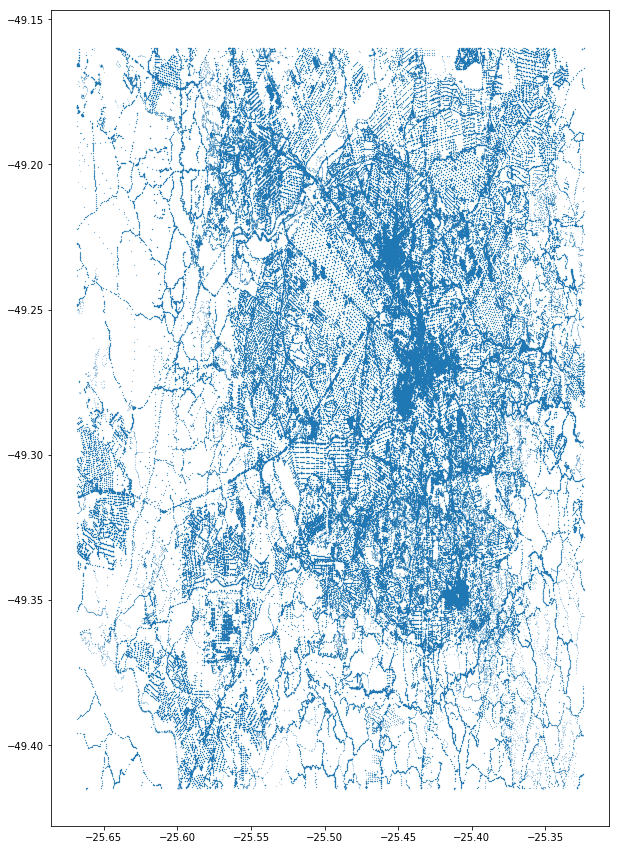

In [41]:
plt.scatter(lat, lon, 0.05, marker='.')

From this plot we can see that our dataset contains much more information than just Curitiba, we have most of the metropolitan area too!

For comparison click here for a map of just Curitiba:

* https://www.openstreetmap.org/relation/297514

### Amenities

In [42]:
query = sql.execute('curitiba.db',
    '''SELECT value, COUNT(*) as num
        FROM nodes_tags
        WHERE key='amenity'
        GROUP BY value
        ORDER BY num DESC
        LIMIT 20
    '''
           )
for (amenity, number) in query[0]:
    print('{:-<20} {:>3}'.format(amenity, number))

restaurant---------- 267
school-------------- 267
fuel---------------- 189
pharmacy------------ 173
bank---------------- 166
fast_food----------- 123
place_of_worship----  77
clinic--------------  73
pub-----------------  71
parking-------------  44
taxi----------------  44
bench---------------  42
cafe----------------  36
atm-----------------  31
bus_station---------  30
parking_entrance----  30
bicycle_parking-----  27
police--------------  27
hospital------------  23
bar-----------------  17


Just 17 bars? This dataset is not complete by a large margin in my experience!

Not surprising restaurants (and schools) take the first spot, we, 'curitibanos', sure like to go out to eat!

* http://gastronomiadescomplicada.blogspot.com.br/2011/09/cenario-gastronomico-curitibano.html

From this article we get the information that the favorite cuisines of the 'curitibanos' are **pizza** and **steak_house** (called *churrascaria* in portuguese), do our data support this view?

In [43]:
sql.execute('curitiba.db',
    '''SELECT nodes_tags.value, COUNT(*) as num
       FROM nodes_tags 
       JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value='restaurant') i
       ON nodes_tags.id=i.id
       WHERE nodes_tags.key='cuisine'
       GROUP BY nodes_tags.value
       ORDER BY num DESC
       LIMIT 5
    '''
           )

[[('pizza', 40),
  ('regional', 38),
  ('steak_house', 17),
  ('italian', 15),
  ('japanese', 12)]]

Yes, but with regional in the second place, during the weekdays we tend to eat reginal food, so not surprising too.

## Additional Ideas

### Fixing missing or wrong postal codes

Postal codes in Brazil changes between blocks, so using latitude and longitude information to get a correct code is difficult.

We can use the Google Maps API, documented here: 
* https://developers.google.com/maps/documentation/geocoding/intro?hl=en-us#ReverseGeocoding 

But wrangling the JSON data we receive from requests to find the correct postal code, based on latitude, longitude and house number is a project in its own, outside the scope of this one. So, here's a valid way that we could improve the data, and even make it so all the missing postal_code information is complete!

An example of using the API to try to fix one problematic postal code found during the data wrangling:

In [44]:
sql.execute('curitiba_dirty.db',
    '''SELECT lat, lon FROM NODES n JOIN Nodes_tags nt ON n.id = nt.id
       WHERE nt.key LIKE 'post%' AND nt.value = '87483-001'
       UNION
       SELECT lat, lon FROM NODES n JOIN ways_nodes wn ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
       WHERE wt.key LIKE 'post%' AND wt.value = '87483-001'
    '''
           ) 
#Using the dirty database, as this data didn't make into the final database 
#due to invalid postal code

[[(-25.5854049, -49.3364096),
  (-25.585306, -49.3368662),
  (-25.5852788, -49.336376),
  (-25.585152700000002, -49.3363424),
  (-25.585133600000002, -49.3368174),
  (-25.585133600000002, -49.336473299999994)]]

Using the first pair of coordinates to create a request:

* http://maps.google.com/maps/api/geocode/json?address=-25.5854049,-49.3364096



Looking at the data found using the link above we can see that the first suggested postal code for this pair of coordinates is **81490-544** which comprises the house number interval of **266 to 360**, but we have a lot more data than just that. 

In this case for example, our data point is not within this house number range:

In [45]:
sql.execute('curitiba_dirty.db',
    '''SELECT nt.key, nt.value FROM NODES n JOIN Nodes_tags nt ON n.id = nt.id
       WHERE lat = -25.5854049 AND lon = -49.3364096
       UNION
       SELECT wt.key, wt.value FROM NODES n JOIN ways_nodes wn ON n.id = wn.node_id
       JOIN ways_tags wt ON wn.id = wt.id
       WHERE lat = -25.5854049 AND lon = -49.3364096
    '''
           )

[[('amenity', 'kindergarten'),
  ('city', 'Curitiba'),
  ('housenumber', '160'),
  ('name', 'CMEI Dona Bertha'),
  ('postcode', '87483-001'),
  ('street', 'Rua Pia Lazzari Bertoldi'),
  ('suburb', 'Campo de Santana')]]

But that is expected, our coordinates (-25.5854049, -49.3364096) are just outside the bounds of this first suggestion:

* Latitude: -25.5852315 to -25.5854355
* Longitude: -49.336302 to -49.3364077

The correct suggestion is **81490-424**, the coordinates are:

* Latitude: -25.5820175 to -25.5861128
* Longitude: -49.3361306 to -49.3373991

So it's possible to implement a way to use the Google Maps API to programmatically fix the postal codes.

Using the name tag for this data point (CMEI Dona Bertha) we can confirm the postal code:

* http://www.educacao.curitiba.pr.gov.br/conteudo/localizacao-dona-bertha-centro-municipal-de-educacao-infantil-/2718

#### Problems:
The problem with this approach is that, while valid for the creation of this project and it's associated database, such information cannot be used to fix OpenStreetMap directly, as it's against the 'Google Maps/Google Earth APIs Terms of Service', particularly this section:
* 10.4.c.i: No creation of a substitute service. You will not use the Service to create a Maps API Implementation that is a substitute for, or substantially similar service to, Google Maps (at https://www.google.com/maps (or such other URL as Google may provide)) ("Google Maps") or the Service.

Also, there's a limit of request we can make to the API before our access is blocked for some time:
* 10.4.b: No use beyond transaction limits and usage policies. If your Maps API Implementation generates a high volume of transactions, Google reserves the right to set transaction limits, as described in the Maps APIs Documentation (https://developers.google.com/maps/faq?hl=en-us#usagelimits). Google also reserves the right to set other usage policies in the Documentation from time to time. If you want to engage in use outside these transaction limits or usage policies, you can purchase more usage capacity through the Maps API Standard pricing plan, or you can contact the Google Maps sales team for licensing options to address your needs. Google may decline your request, or condition acceptance on your agreement to additional terms and/or charges for that use.

More information can be found here:
* https://developers.google.com/maps/terms?hl=pt-br#10-license-restrictions

## Conclusion

After wrangling and cleaning the data I'm sure it's in a better state than before. It's obvious, too, that the dataset is incomplete (come on just 17 bars?).

The missing or wrong postal codes is an issue that may prevent this data from being used in a production enviroment, but analysing it as a community effort, it's pretty impressive what we already have.

SQL proved to be important when cleaning the data, as in many instances, without a database it'd be harder to find and correct the problems in the dataset.

## References

* Udacity's Data Analyst Nanodegree material and forums
* Wikipedia
* OpenStreetMap's wiki: https://wiki.openstreetmap.org/
* MapZen: https://mapzen.com/
* Google Maps
* http://www.ufpr.br/portalufpr/campi/
* https://thiagorodrigo.com.br/artigo/cep-brasil-lista-de-cep-por-estados-capitais-e-interior/
* http://gastronomiadescomplicada.blogspot.com.br/2011/09/cenario-gastronomico-curitibano.html
* Google Maps API documentation: https://developers.google.com/maps/documentation/geocoding/intro?hl=en-us
* http://www.educacao.curitiba.pr.gov.br/conteudo/localizacao-dona-bertha-centro-municipal-de-educacao-infantil-/2718
